In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from math import sqrt

2024-02-20 18:43:56.684400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv("../kaggle/coin_gecko_2022-03-16.csv")
df2 = pd.read_csv("../kaggle/coin_gecko_2022-03-17.csv")

In [4]:
df.head()

,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date
0,Bitcoin,BTC,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16
1,Ethereum,ETH,2744.410000,0.024,0.034,0.065,1.974870e+10,3.271044e+11,2022-03-16
2,Tether,USDT,1.000000,-0.001,-0.001,0.000,5.793497e+10,7.996516e+10,2022-03-16
3,BNB,BNB,383.430000,0.018,0.028,0.004,1.395854e+09,6.404382e+10,2022-03-16
4,USD Coin,USDC,0.999874,-0.001,0.000,-0.000,3.872274e+09,5.222214e+10,2022-03-16


In [5]:
# checking if missing values come from the same coin
df[df["1h"].isnull()==True].index, df[df["24h"].isnull()==True].index, df[df["7d"].isnull()==True].index, df[df["24h_volume"].isnull()==True].index 

(Index([310, 416, 472], dtype='int64'),
 Index([310, 416, 472], dtype='int64'),
 Index([310, 416, 472], dtype='int64'),
 Index([310, 416, 472], dtype='int64'))

In [6]:
# removing the row with missing value 
df = df.drop([310, 416, 472])

In [7]:
# add price and price changes in 1h, 24h, 7d to know the movement of the price 
df["price_7d"] = df["price"] + df["7d"]
df["price_24h"] = df["price"] + df["24h"]
df["price_1h"] = df["price"] + df["1h"]

In [8]:
df["coin"].unique(), df["symbol"].unique()

(array(['Bitcoin', 'Ethereum', 'Tether', 'BNB', 'USD Coin', 'XRP', 'Terra',
        'Solana', 'Cardano', 'Polkadot', 'Avalanche', 'Binance USD',
        'Dogecoin', 'TerraUSD', 'Shiba Inu', 'Wrapped Bitcoin', 'Cronos',
        'Polygon', 'Dai', 'Cosmos Hub', 'Litecoin', 'Lido Staked Ether',
        'Near', 'Chainlink', 'TRON', 'FTX Token', 'Bitcoin Cash',
        'LEO Token', 'OKB', 'Algorand', 'Stellar', 'Uniswap', 'Hedera',
        'Axie Infinity', 'Decentraland', 'Ethereum Classic', 'Elrond',
        'The Sandbox', 'Internet Computer', 'Monero', 'cETH', 'VeChain',
        'Fantom', 'Filecoin', 'Osmosis', 'Klaytn', 'Frax', 'Waves',
        'Theta Network', 'Magic Internet Money', 'The Graph', 'Tezos',
        'cUSDC', 'Helium', 'THORChain', 'EOS', 'ECOMI', 'IOTA', 'cDAI',
        'Flow', 'Theta Fuel', 'Aave', 'Zcash', 'Maker', 'JUNO', 'Gala',
        'BitTorrent', 'Arweave', 'Huobi BTC', 'PancakeSwap', 'Quant',
        'Harmony', 'eCash', 'Bitcoin SV', 'NEO', 'TrueUSD', 'Huobi Token'

In [9]:
df["coin"].nunique(), df["symbol"].nunique() 

(497, 494)

497 coins and 494 symbols in the dataset, single row for each coin

In [10]:
df.head()

,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date,price_7d,price_24h,price_1h
0,Bitcoin,BTC,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16,40859.515000,40859.490000,40859.482000
1,Ethereum,ETH,2744.410000,0.024,0.034,0.065,1.974870e+10,3.271044e+11,2022-03-16,2744.475000,2744.444000,2744.434000
2,Tether,USDT,1.000000,-0.001,-0.001,0.000,5.793497e+10,7.996516e+10,2022-03-16,1.000000,0.999000,0.999000
3,BNB,BNB,383.430000,0.018,0.028,0.004,1.395854e+09,6.404382e+10,2022-03-16,383.434000,383.458000,383.448000
4,USD Coin,USDC,0.999874,-0.001,0.000,-0.000,3.872274e+09,5.222214e+10,2022-03-16,0.999874,0.999874,0.998874


# Training ARIMA model on all data

In [11]:
model = ARIMA(df["price"], order=(1,1,1))
model_fit = model.fit()

/Users/malvikavaidya/Documents/UT_Austin/Senior_Design/FH03-Senior-Design-Project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/malvikavaidya/Documents/UT_Austin/Senior_Design/FH03-Senior-Design-Project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/malvikavaidya/Documents/UT_Austin/Senior_Design/FH03-Senior-Design-Project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  497
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4870.947
Date:                Thu, 18 Jan 2024   AIC                           9747.894
Time:                        17:59:51   BIC                           9760.513
Sample:                             0   HQIC                          9752.847
                                - 497                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0252      0.045      0.557      0.578      -0.064       0.114
ma.L1         -0.9908      0.009   -108.272      0.000      -1.009      -0.973
sigma2      2.281e+07   3.43e-10   6.66e+16      0.0

In [13]:
forecast = model_fit.forecast(steps=5)
print(forecast)

497    323.850826
498    332.002440
499    332.207830
500    332.213005
501    332.213135
Name: predicted_mean, dtype: float64


/Users/malvikavaidya/Documents/UT_Austin/Senior_Design/FH03-Senior-Design-Project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/malvikavaidya/Documents/UT_Austin/Senior_Design/FH03-Senior-Design-Project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# ARIMA model with Train and Test Data

In [98]:

# print indexes
print(df["price"].index)

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       490, 491, 492, 493, 494, 495, 496, 497, 498, 499],
      dtype='int64', length=497)


In [99]:
size = int(len(df) * 0.8)
train, test = df[0:size], df[size:len(df)]
train_price = train["price"]
test_price = test["price"]

In [100]:
print(test_price.index)

Index([398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
       412, 413, 414, 415, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440,
       441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454,
       455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483,
       484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497,
       498, 499],
      dtype='int64')
100


In [93]:
model = ARIMA(train_price, order=(2, 2, 2))  
model_fit = model.fit()

/Users/malvikavaidya/Documents/UT_Austin/Senior_Design/FH03-Senior-Design-Project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/malvikavaidya/Documents/UT_Austin/Senior_Design/FH03-Senior-Design-Project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/malvikavaidya/Documents/UT_Austin/Senior_Design/FH03-Senior-Design-Project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/malvikavaidya/Documents/UT_Austin/Senior_Design/FH03-Senior-Design-Project/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWar

In [108]:
forecasted_values = model_fit.forecast(steps=len(test_price))
print(forecasted_values)
if np.isnan(forecasted_values).any():
    print("Forecast contains NaN values")
# get length of forecasted values
print(len(forecasted_values))
forecasted_values.index = test_price.index

print(forecasted_values)
if np.isnan(forecasted_values).any():
    print("Predictions contains NaN values")

397    491.282719
398    513.019077
399    505.132176
400    503.131150
401    501.864598
          ...    
492    380.205908
493    378.868858
494    377.531807
495    376.194757
496    374.857706
Name: predicted_mean, Length: 100, dtype: float64
100
398    491.282719
399    513.019077
400    505.132176
401    503.131150
402    501.864598
          ...    
495    380.205908
496    378.868858
497    377.531807
498    376.194757
499    374.857706
Name: predicted_mean, Length: 100, dtype: float64


/Users/malvikavaidya/Documents/UT_Austin/Senior_Design/FH03-Senior-Design-Project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/malvikavaidya/Documents/UT_Austin/Senior_Design/FH03-Senior-Design-Project/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [109]:
# Calculate and print the mean squared error

mse = mean_squared_error(test_price, forecasted_values)
rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 835.240


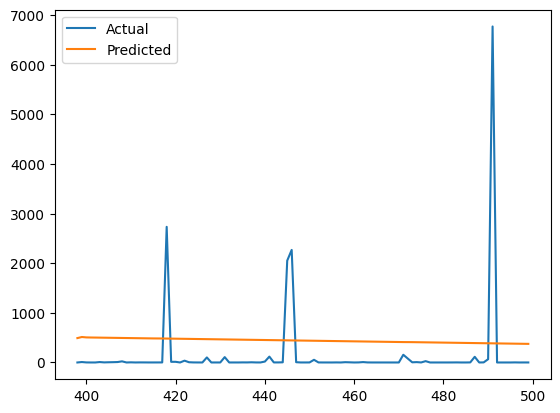

In [110]:
# Plot the predictions against the true values
plt.plot(test_price, label='Actual')
plt.plot(forecasted_values, label='Predicted')
plt.legend()
plt.show()

# Simulating Incremental Learning with ARIMA

In [ ]:
model_updated = model_fit.append(new_data, refit=False)
forecast = model_updated.forecast(steps=n)

# Training LSTM Model Univariate Time Series Forecasting

In [114]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

In [112]:
data = df['price'].values.reshape(-1, 1)

In [115]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [116]:
# Function to create a dataset for LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

In [117]:
time_step = 10
X, y = create_dataset(scaled_data, time_step)

In [118]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

In [119]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size], X[train_size:len(X)]
train_y, test_y = y[0:train_size], y[train_size:len(y)]

In [127]:


model = Sequential([
    LSTM(50, stateful=True, batch_input_shape=(batch_size, time_step, train_X.shape[2])),
    Dense(1)
])

In [121]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [122]:
batch_size = 1  
for i in range(len(train_X)):
    # Use one sample at a time for training to simulate incremental learning
    model.train_on_batch(train_X[i:i+1], train_y[i:i+1])

In [123]:
test_predict = model.predict(test_X)

4/4 [==============================] - 0s 3ms/step


In [124]:
# Invert the scaling for prediction
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])

In [125]:
test_score = np.sqrt(np.mean((test_predict - test_y) ** 2))
print(f"RMSE: {test_score}")

RMSE: 891.3899078659211


# Incremental Learning with LSTM

# Multivariate Time Series Forecasting with LSTM

In [137]:

df_numeric = df.drop(columns=['coin', 'symbol', 'date'])
df_numeric.head()

,price,1h,24h,7d,24h_volume,mkt_cap,price_7d,price_24h,price_1h
0,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,40859.515000,40859.490000,40859.482000
1,2744.410000,0.024,0.034,0.065,1.974870e+10,3.271044e+11,2744.475000,2744.444000,2744.434000
2,1.000000,-0.001,-0.001,0.000,5.793497e+10,7.996516e+10,1.000000,0.999000,0.999000
3,383.430000,0.018,0.028,0.004,1.395854e+09,6.404382e+10,383.434000,383.458000,383.448000
4,0.999874,-0.001,0.000,-0.000,3.872274e+09,5.222214e+10,0.999874,0.999874,0.998874


In [139]:
def create_multivariate_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])

        y.append(data[i + time_step, -1])
    return np.array(X), np.array(y)

In [140]:
values = df_numeric.values  # convert to numpy array

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)
X, y = create_multivariate_sequences(scaled_values, time_step)

X = X.reshape((X.shape[0], time_step, X.shape[2]))

In [145]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size], X[train_size:len(X)]
train_y, test_y = y[0:train_size], y[train_size:len(y)]

In [146]:

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [147]:
model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100
11/11 [==============================] - 4s 73ms/step - loss: 0.0161 - val_loss: 0.0034
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0150 - val_loss: 0.0030
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0146 - val_loss: 0.0027
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0146 - val_loss: 0.0028
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0149 - val_loss: 0.0027
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0146 - val_loss: 0.0027
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.0027
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0147 - val_loss: 0.0028
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.0027
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0144 - val_loss: 0.0028
Epoch 11

In [152]:
test_predict = model.predict(test_X)

dummy_test_array = np.zeros((len(test_predict), test_X.shape[2]))


dummy_test_array[:, -1] = test_predict.flatten()

test_predict = scaler.inverse_transform(dummy_test_array)[:, -1]
dummy_true_array = np.zeros_like(dummy_test_array)
dummy_true_array[:, -1] = test_y
test_y = scaler.inverse_transform(dummy_true_array)[:, -1]


test_score = np.sqrt(np.mean((test_predict - test_y) ** 2))
print(f"RMSE: {test_score}")

4/4 [==============================] - 0s 3ms/step
RMSE: 1122.302751521683
